In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [2]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## Showing the Compounds Numbers before preprocessing

In [3]:
suppl = Chem.SDMolSupplier("../data/ChirBase/chirbase.sdf")
mols = [x for x in suppl if x is not None]

csp_no = {'SMILES': [], 'MB': [], 'Chir_Tag': [], 'SMILES_iso': [], 'K2/K1': []}

for mol in mols: 
    if mol.HasProp('csp_no'):
        mb = mol.GetProp('csp_no')
    else: 
        mb = 'unknown'
    smiles_iso = Chem.MolToSmiles(mol, isomericSmiles=True)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    # chir_tag = ';'.join([str(atom.GetChiralTag()) for atom in Chem.MolFromSmiles(smiles_iso).GetAtoms()])
    chir_tag = ';'.join(['0' if str(atom.GetChiralTag()) == 'CHI_UNSPECIFIED' else '1' for atom in Chem.MolFromSmiles(smiles_iso).GetAtoms()])
    
    csp_no['SMILES_iso'].append(smiles_iso)
    csp_no['SMILES'].append(smiles)
    csp_no['Chir_Tag'].append(chir_tag)
    csp_no['MB'].append(mb)
    csp_no['K2/K1'].append(mol.GetProp('k2/k1'))
        
scp_no_df = pd.DataFrame.from_dict(csp_no)

scp_no_df = scp_no_df.drop_duplicates(subset=['SMILES', 'MB', 'Chir_Tag'])

scp_no_sum_df = scp_no_df.groupby(['MB']).size().to_frame(name='mol_num')
scp_no_sum_df = scp_no_sum_df.sort_values(by=['mol_num']).reset_index()

In [4]:
scp_no_sum_df[scp_no_sum_df['MB']=='91119']

,MB,mol_num
1579,91119,308


In [5]:
scp_no_sum_df[scp_no_sum_df['MB']=='3575']

,MB,mol_num
1567,3575,189


In [6]:
scp_no_sum_df[-20:]

,MB,mol_num
1583,90704,351
1584,90200,399
1585,90216,437
1586,15723,462
1587,90201,472
1588,90357,533
1589,394,574
1590,90292,610
1591,2,642
1592,91423,680


Any same enantiomers but different configurations? Yes!

In [26]:
df_tmp = scp_no_df.groupby(['SMILES', 'MB']).filter(lambda x: len(x['Chir_Tag']) >= 2).reset_index(drop=True)

In [27]:
df_tmp

,SMILES,MB,Chir_Tag,SMILES_iso,K2/K1
0,CCCCCCCCCCCCCCCC(=O)OCC(COC(=O)Nc1cc([N+](=O)[...,90234,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;...,CCCCCCCCCCCCCCCC(=O)OC[C@H](COC(=O)Nc1cc([N+](...,1.440000000000000e+000
1,O=C1OCCN1C(=O)C1CC2C=CC1C2,45173,0;0;0;0;0;0;0;0;1;0;0;0;0;0;0,O=C1OCCN1C(=O)[C@H]1CC2C=CC1C2,1.383600000000000e+000
2,CCCCCCCCCCCCCCCC(=O)OC(COC(=O)CCC)COC(=O)Nc1cc...,90234,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,CCCCCCCCCCCCCCCC(=O)OC(COC(=O)CCC)COC(=O)Nc1cc...,1.360000000000000e+000
3,CCCCCCCCCCCCCCCC(=O)OCC(COC(=O)Nc1cc([N+](=O)[...,90234,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,CCCCCCCCCCCCCCCC(=O)OCC(COC(=O)Nc1cc([N+](=O)[...,1.440000000000000e+000
4,O=C(CC(C[N+](=O)[O-])c1ccccc1)c1ccccc1,45167,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,O=C(CC(C[N+](=O)[O-])c1ccccc1)c1ccccc1,1.431910000000000e+000
5,CCCCCCCCCCCCCCCC(=O)OC(COC(=O)CCC)COC(=O)Nc1cc...,90234,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;...,CCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCC)COC(=O)N...,1.290000000000000e+000
6,CC(O)c1ccc([N+](=O)[O-])cc1,90246,0;1;0;0;0;0;0;0;0;0;0;0,C[C@H](O)c1ccc([N+](=O)[O-])cc1,1.105850000000000e+000
7,O=C(CC(C[N+](=O)[O-])c1ccccc1)c1ccccc1,45167,0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,O=C(C[C@@H](C[N+](=O)[O-])c1ccccc1)c1ccccc1,1.350320000000000e+000
8,CC(=O)CC(O)c1ccc(Cl)cc1,45167,0;0;0;0;1;0;0;0;0;0;0;0;0,CC(=O)C[C@H](O)c1ccc(Cl)cc1,1.271070000000000e+000
9,O=C1OCCN1C(=O)C1CC2C=CC1C2,45173,0;0;0;0;0;0;0;0;1;0;1;0;0;0;0,O=C1OCCN1C(=O)[C@H]1C[C@H]2C=CC1C2,1.127610000000000e+000


In [44]:
def find_the_other_enantimer(smiles1): 
    mol1 = Chem.MolFromSmiles(smiles1)
    chir_tag1 = ';'.join(['0' if str(atom.GetChiralTag()) == 'CHI_UNSPECIFIED' else '1' for atom in mol1.GetAtoms()])
    print(chir_tag1, smiles1)
    print('===')
    
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles1), isomericSmiles=False)
    mol = Chem.MolFromSmiles(smiles)
    opts = StereoEnumerationOptions(unique=True)
    isomers = tuple(EnumerateStereoisomers(mol, options=opts))
    print('{} isomers are found!\n'.format(len(isomers)))

    flag = False
    for mol2 in isomers: 
        smiles2 = Chem.MolToSmiles(mol2, isomericSmiles=True)
        mol2 = Chem.MolFromSmiles(smiles2)
        chir_tag2 = ';'.join(['0' if str(atom.GetChiralTag()) == 'CHI_UNSPECIFIED' else '1' for atom in mol2.GetAtoms()])
        
        print(chir_tag2, smiles2)
        if chir_tag2 == chir_tag1 and smiles2 != smiles1:
            flag = True
            break
    assert flag == True, 'Can not find the enantiomers for {}'.format(smiles1)
    if flag: 
        return smiles2, mol2
    else:
        return smiles1, mol1

In [45]:
find_the_other_enantimer(df_tmp.iloc[24, :]['SMILES_iso'])

0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(=C/[C@@H](NC(=O)c1ccccc1)c1ccccc1)/C=N/N1CCCC1
===
8 isomers are found!

0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(/C=N/N1CCCC1)=C\[C@H](NC(=O)c1ccccc1)c1ccccc1
0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(/C=N/N1CCCC1)=C\[C@@H](NC(=O)c1ccccc1)c1ccccc1
0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(/C=N\N1CCCC1)=C\[C@H](NC(=O)c1ccccc1)c1ccccc1
0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(/C=N\N1CCCC1)=C\[C@@H](NC(=O)c1ccccc1)c1ccccc1
0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(=C/[C@H](NC(=O)c1ccccc1)c1ccccc1)/C=N/N1CCCC1


('CC(C)C(=C/[C@H](NC(=O)c1ccccc1)c1ccccc1)/C=N/N1CCCC1',
 <rdkit.Chem.rdchem.Mol at 0x7fcd065b7670>)

In [47]:
find_the_other_enantimer(df_tmp.iloc[25, :]['SMILES_iso'])

0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(/C=N/N1CCCC1)=C\[C@@H](NC(=O)c1ccccc1)c1ccccc1
===
8 isomers are found!

0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0 CC(C)C(/C=N/N1CCCC1)=C\[C@H](NC(=O)c1ccccc1)c1ccccc1


('CC(C)C(/C=N/N1CCCC1)=C\\[C@H](NC(=O)c1ccccc1)c1ccccc1',
 <rdkit.Chem.rdchem.Mol at 0x7fcd065b73f0>)

What is the unique non-isomeric SMILES number?

In [7]:
smiles_list_chirbase = [Chem.CanonSmiles(Chem.MolToSmiles(m, isomericSmiles=False)) for m in mols]
smiles_list_chirbase = list(set(smiles_list_chirbase))

print('{} unique compounds are contained in ChirBase'.format(len(smiles_list_chirbase)))

42003 unique compounds are contained in ChirBase


In [8]:
df_rt = pd.read_csv('../data/CMRT/cmrt_all_column.csv', index_col=0)

df_rt['isomer_SMILES'] = df_rt['SMILES']
df_rt['SMILES'] = df_rt['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

# df_rt = df_rt.sort_values(['index', 'RT'], ascending=False)

df_rt = df_rt[df_rt['RT'] != 0]
df_rt = df_rt.groupby(['index']).filter(lambda x: len(x) == 2)

In [9]:
df_rt.groupby(['Column']).size()

Column
AD      584
AD3     564
ADH    4884
AS      312
ASH    1068
AZ      344
IA     1610
IAH      72
IAU      54
IB      600
IC     1862
IC3     954
ICH     216
ID      534
IE      920
IF      442
IF3     158
IG      234
OD      356
OD3     742
ODH    4520
OJ      222
OJ3     264
OJH    1710
OZ3     212
dtype: int64

## ChirBase

In [8]:
suppl = Chem.SDMolSupplier("../data/ChirBase/chirbase_clean4.sdf")
mols = [x for x in suppl if x is not None]

In [9]:
df_dict = {'SMILES': [], 'isomer_SMILES': [], 'MB': [], 'CSP_category': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    smiles_iso = Chem.CanonSmiles(Chem.MolToSmiles(mol))
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['isomer_SMILES'].append(smiles_iso)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['CSP_category'].append(mol.GetProp('mobile_phase_category'))
    df_dict['Y'].append(y)

df = pd.DataFrame.from_dict(df_dict)

In [10]:
df['MB'] = df['MB'].astype(int)
# MB_dict = {91423: 'Chiralpak IB', 91119: 'Chirobiotic TAG', 90879: 'Chirobiotic T', 90704: 'Chirobiotic V', 90589: 'Whelk-O', 
#            90357: 'Cyclobond I RN', 90246: 'Chiralcel OJ (Lux Cellulose-3)', 90211: 'Pirkle (R or S)-DNBPG', 
#            45173: 'Chiralcel OD (Lux Cellulose-1)', 45167: 'Chiralpak AS', 44869: 'Chiralcel OB',
#            23735: 'Chiralpak AD', 15723: 'Chirobiotic R', 394: 'Chiral-AGP', 91518: 'Chiralpak IC (Sepapak 5)', 
#            2: 'Cyclobond I', 45172: 'Chiralpak IA', 3575: 'Ultron-ES-OVM',}
MB_dict = {0: 'Chiralpak IB', 1: 'Chirobiotic TAG', 2: 'Chirobiotic T', 3: 'Chirobiotic V', 4: 'Whelk-O', 
           5: 'Cyclobond I RN', 6: 'Chiralcel OJ (Lux Cellulose-3)', 7: 'Pirkle (R or S)-DNBPG', 
           8: 'Chiralcel OD (Lux Cellulose-1)', 9: 'Chiralpak AS', 10: 'Chiralcel OB',
           11: 'Chiralpak AD', 12: 'Chirobiotic R', 13: 'Chiral-AGP', 14: 'Chiralpak IC (Sepapak 5)', 
           15: 'Cyclobond I', 16: 'Chiralpak IA', 17: 'Ultron-ES-OVM',}
df['Column'] = df['MB'].apply(lambda x: MB_dict[x])

In [11]:
df

,SMILES,isomer_SMILES,MB,CSP_category,K2/K1,Y,Column
0,CCC(=O)OC(C)c1ccccc1,CCC(=O)O[C@@H](C)c1ccccc1,15,1,1.0100,0,Cyclobond I
1,CC(=O)OC(C)c1ccccc1,CC(=O)O[C@@H](C)c1ccccc1,15,1,1.0300,0,Cyclobond I
2,O=C(O)C(Cl)c1ccccc1,O=C(O)[C@@H](Cl)c1ccccc1,15,1,1.0300,0,Cyclobond I
3,CCCC(C(N)=O)c1ccc(O)c(O)c1,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1,1.3100,2,Cyclobond I
4,COc1ccccc1C(C)O,COc1ccccc1[C@H](C)O,15,1,1.0400,0,Cyclobond I
...,...,...,...,...,...,...,...
43780,O=C(c1ccccc1)c1ccc2n1CCC2C(=O)O,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2,2.0000,3,Chiral-AGP
43781,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,2,1.8069,2,Chiralpak AD
43782,CCCS(=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,16,1,2.1600,3,Chiralpak IA
43783,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)CC1c1ccccc1,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,2,5.0000,3,Chiralcel OJ (Lux Cellulose-3)


In [13]:
df.groupby(['MB']).size()

MB
0       668
1       308
2      1154
3       351
4      1687
5       533
6      4152
7      1334
8     13681
9      3586
10     1257
11    10850
12      460
13      575
14     1018
15      639
16     1343
17      189
dtype: int64

## CMRT

In [14]:
suppl = Chem.SDMolSupplier("../data/CMRT/cmrt_clean.sdf")
mols = [x for x in suppl if x is not None]

In [15]:
df_dict = {'SMILES': [], 'isomer_SMILES': [], 'MB': [], 'CSP_category': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    smiles_iso = Chem.CanonSmiles(Chem.MolToSmiles(mol))
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['isomer_SMILES'].append(smiles_iso)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['CSP_category'].append(mol.GetProp('mobile_phase_category'))
    df_dict['Y'].append(y)

df_cmrt = pd.DataFrame.from_dict(df_dict)

In [16]:
df_cmrt['MB'] = df_cmrt['MB'].astype(int)
# MB_dict = {91423: 'Chiralpak IB', 91119: 'Chirobiotic TAG', 90879: 'Chirobiotic T', 90704: 'Chirobiotic V', 90589: 'Whelk-O', 
#            90357: 'Cyclobond I RN', 90246: 'Chiralcel OJ (Lux Cellulose-3)', 90211: 'Pirkle (R or S)-DNBPG', 
#            45173: 'Chiralcel OD (Lux Cellulose-1)', 45167: 'Chiralpak AS', 44869: 'Chiralcel OB',
#            23735: 'Chiralpak AD', 15723: 'Chirobiotic R', 394: 'Chiral-AGP', 91518: 'Chiralpak IC (Sepapak 5)', 
#            2: 'Cyclobond I', 45172: 'Chiralpak IA', 3575: 'Ultron-ES-OVM',}
MB_dict = {0: 'Chiralpak IB', 1: 'Chirobiotic TAG', 2: 'Chirobiotic T', 3: 'Chirobiotic V', 4: 'Whelk-O', 
           5: 'Cyclobond I RN', 6: 'Chiralcel OJ (Lux Cellulose-3)', 7: 'Pirkle (R or S)-DNBPG', 
           8: 'Chiralcel OD (Lux Cellulose-1)', 9: 'Chiralpak AS', 10: 'Chiralcel OB',
           11: 'Chiralpak AD', 12: 'Chirobiotic R', 13: 'Chiral-AGP', 14: 'Chiralpak IC (Sepapak 5)', 
           15: 'Cyclobond I', 16: 'Chiralpak IA', 17: 'Ultron-ES-OVM',}
df_cmrt['Column'] = df_cmrt['MB'].apply(lambda x: MB_dict[x])

In [17]:
df_cmrt

,SMILES,isomer_SMILES,MB,CSP_category,K2/K1,Y,Column
0,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,1,0.7792,0,Chiralpak IA
1,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,1,0.7792,0,Chiralpak IA
2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,16,1,0.3095,0,Chiralpak IA
3,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(Cl)cc2)cc1,16,1,0.3095,0,Chiralpak IA
4,Cc1ccc(S(=O)(=O)CC2CCCc3ccccc32)cc1,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,2,2.7838,3,Chiralpak IB
...,...,...,...,...,...,...,...
5401,CC(=O)NNC(C=Cc1ccccc1)c1ccc(C)cc1,CC(=O)NN[C@@H](/C=C/c1ccccc1)c1ccc(C)cc1,6,2,1.0833,1,Chiralcel OJ (Lux Cellulose-3)
5402,O=C1OC(N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccccc21,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,16,1,1.2459,2,Chiralpak IA
5403,O=C1OC(N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccccc21,O=C1O[C@@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2cc...,16,1,1.2459,2,Chiralpak IA
5404,COC(=O)CC(O)c1ccc(N(C)C)cc1,COC(=O)C[C@@H](O)c1ccc(N(C)C)cc1,16,1,1.1218,0,Chiralpak IA


In [18]:
df_cmrt = df_cmrt.drop_duplicates(subset=['SMILES'])

In [19]:
df_cmrt.groupby(['MB']).size()

MB
0     285
6     102
8     171
9     151
11    269
14    893
16    727
dtype: int64

## Overlap

In [20]:
df_overlap = df_cmrt[['SMILES', 'MB']].merge(df[['SMILES', 'MB']], how='inner')

In [21]:
df_overlap.groupby(['MB']).size()

MB
6      5
8      8
9     13
11    14
14    21
16    25
dtype: int64

In [22]:
print("{} overlapped samples".format(len(df_overlap)))

86 overlapped samples


## Class distribution

In [23]:
df

,SMILES,isomer_SMILES,MB,CSP_category,K2/K1,Y,Column
0,CCC(=O)OC(C)c1ccccc1,CCC(=O)O[C@@H](C)c1ccccc1,15,1,1.0100,0,Cyclobond I
1,CC(=O)OC(C)c1ccccc1,CC(=O)O[C@@H](C)c1ccccc1,15,1,1.0300,0,Cyclobond I
2,O=C(O)C(Cl)c1ccccc1,O=C(O)[C@@H](Cl)c1ccccc1,15,1,1.0300,0,Cyclobond I
3,CCCC(C(N)=O)c1ccc(O)c(O)c1,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1,1.3100,2,Cyclobond I
4,COc1ccccc1C(C)O,COc1ccccc1[C@H](C)O,15,1,1.0400,0,Cyclobond I
...,...,...,...,...,...,...,...
43780,O=C(c1ccccc1)c1ccc2n1CCC2C(=O)O,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2,2.0000,3,Chiral-AGP
43781,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,2,1.8069,2,Chiralpak AD
43782,CCCS(=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,16,1,2.1600,3,Chiralpak IA
43783,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)CC1c1ccccc1,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,2,5.0000,3,Chiralcel OJ (Lux Cellulose-3)


In [24]:
df_cmrt

,SMILES,isomer_SMILES,MB,CSP_category,K2/K1,Y,Column
0,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,16,1,0.7792,0,Chiralpak IA
2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Cl)cc2)cc1,16,1,0.3095,0,Chiralpak IA
4,Cc1ccc(S(=O)(=O)CC2CCCc3ccccc32)cc1,Cc1ccc(S(=O)(=O)C[C@H]2CCCc3ccccc32)cc1,0,2,2.7838,3,Chiralpak IB
6,Cc1ccc(S(=O)(=O)CC(C)c2cccs2)cc1,Cc1ccc(S(=O)(=O)C[C@H](C)c2cccs2)cc1,16,1,1.2706,2,Chiralpak IA
8,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Br)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(Br)cc2)cc1,16,1,1.3404,2,Chiralpak IA
...,...,...,...,...,...,...,...
5396,C=CC=CCC(C=O)(CC)c1ccccc1,C=C/C=C/C[C@](C=O)(CC)c1ccccc1,9,2,1.0808,1,Chiralpak AS
5398,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,C[C@]1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,2,1.4901,2,Chiralpak IB
5400,CC(=O)NNC(C=Cc1ccccc1)c1ccc(C)cc1,CC(=O)NN[C@H](/C=C/c1ccccc1)c1ccc(C)cc1,6,2,1.0833,1,Chiralcel OJ (Lux Cellulose-3)
5402,O=C1OC(N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccccc21,O=C1O[C@H](N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccc...,16,1,1.2459,2,Chiralpak IA


In [25]:
chir_cnt = df.groupby(['Column', 'Y']).size().to_frame('Size').reset_index()

cmrt_cnt = df_cmrt.groupby(['Column', 'Y']).size().to_frame('Size').reset_index()

In [26]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [18, 7]})

# chir_cnt.pivot(index='Column', columns='Y', values='Size').plot(kind="bar", stacked=False,
#                                                                 logy=True, ax=axs[0])
# axs[0].legend(title='Class')
# cmrt_cnt.pivot(index='Column', columns='Y', values='Size').plot(kind="bar", stacked=False, 
#                                                                 logy=True, ax=axs[1])
# axs[1].legend(title='Class')

# fig.tight_layout()
# plt.show()

Calculate the percentage

In [27]:
cmrt_cnt_all = cmrt_cnt.groupby('Column')['Size'].sum().to_frame('Size_all').reset_index()
cmrt_cnt = cmrt_cnt.merge(cmrt_cnt_all, on='Column', how='left')
cmrt_cnt['Percentage'] = cmrt_cnt.apply(lambda x: x['Size']/x['Size_all'], axis=1)

chir_cnt_all = chir_cnt.groupby('Column')['Size'].sum().to_frame('Size_all').reset_index()
chir_cnt = chir_cnt.merge(chir_cnt_all, on='Column', how='left')
chir_cnt['Percentage'] = chir_cnt.apply(lambda x: x['Size']/x['Size_all'], axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


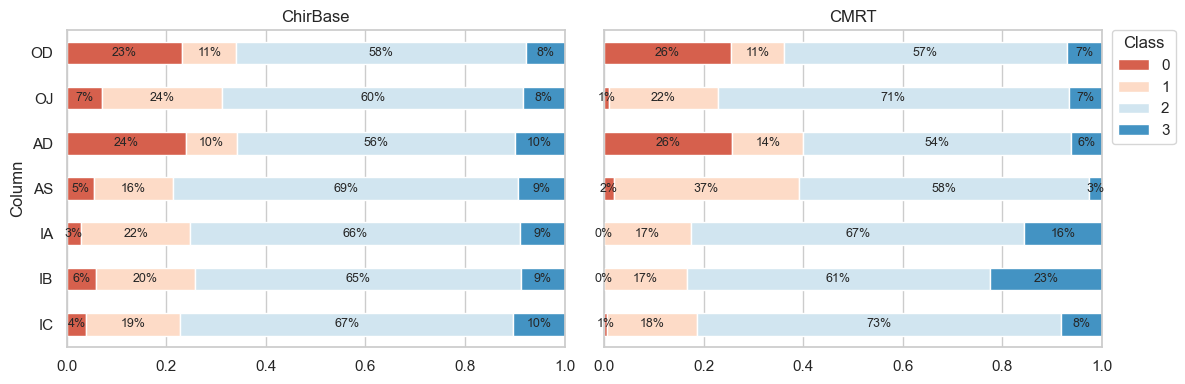

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
palette = sns.color_palette('RdBu', n_colors=4)

chir_cnt[chir_cnt['Column'].isin(cmrt_cnt['Column'])].pivot(index='Column', 
                                                            columns='Y', 
                                                            values='Percentage').plot(kind="barh", 
                                                                                      stacked=True, 
                                                                                      color=palette, 
                                                                                      ax=axs[0]).set(title='ChirBase')
axs[0].legend([],[], frameon=False)
axs[0].set_yticklabels(['IC', 'IB', 'IA', 'AS', 'AD', 'OJ', 'OD'])
for i in axs[0].containers:
    axs[0].bar_label(i, labels=[f'{x:.0%}' for x in i.datavalues], fontsize=9, label_type='center')
axs[0].set(xlim=(0,1))

cmrt_cnt.pivot(index='Column', 
               columns='Y', 
               values='Percentage').plot(kind="barh", 
                                         stacked=True, 
                                         color=palette, 
                                         ax=axs[1]).set(title='CMRT')
axs[1].legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
axs[1].set_yticklabels(['IC', 'IB', 'IA', 'AS', 'AD', 'OJ', 'OD'])
for i in axs[1].containers:
    axs[1].bar_label(i, labels=[f'{x:.0%}' for x in i.datavalues], fontsize=9, label_type='center')
axs[1].set(xlim=(0,1))

fig.tight_layout()
plt.savefig('./compare_chirbase_cmrt_class.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./compare_chirbase_cmrt_class.png', dpi=600, bbox_inches='tight')
plt.show()

## Extra

In [29]:
# from rdkit import Chem
# from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=False
# IPythonConsole.molSize = 300,300

In [30]:
# for s in df['SMILES'].tolist(): 
#     m = Chem.MolFromSmiles(s)
#     isomers = tuple(EnumerateStereoisomers(m))
#     if len(isomers) != 2: 
#         print('\n{} isomers are found!\n'.format(len(isomers)))

#         for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in isomers):
#             print(smi)